In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd/content/drive/MyDrive/FacialEmotionRecognition

/content/drive/MyDrive/FacialEmotionRecognition


In [22]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import cv2
import tensorflow as tf
from keras.initializers import RandomNormal
from keras.layers import *
from keras.optimizers import *
from keras.utils import np_utils
import time
%matplotlib inline

In [23]:
data = pd.read_csv('fer2013.csv')

pixel_data = data['pixels']
label_data = data['emotion']

In [ ]:
data.head()

In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

In [ ]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [24]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)

 

  return X

In [25]:
oversampler =RandomOverSampler(sampling_strategy={0:6000, 1:6000, 2:6500, 3:9500, 4:6700,5:6000,6:6700})

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

X_over_series = pd.Series(X_over.flatten())

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (9500) in class 3 will be larger than the number of samples in the majority class (class #3 -> 8989)
  f"After over-sampling, the number of samples ({n_samples})"


In [13]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = Y_over.value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,5000
1,Fear,6500
2,Sad,6500
3,Neutral,6500
4,Happy,9000
5,Surprise,4200
6,Digust,6000


In [14]:
undersampler =RandomUnderSampler(sampling_strategy={0:4000, 1:5000, 2:6000, 3:7000, 4:6000,5:4100,6:6200})

X_over, Y_over = undersampler.fit_resample(X_over.reshape(-1,1), Y_over)
X_over_series = pd.Series(X_over.flatten())

In [15]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = Y_over.value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4000
1,Digust,5000
2,Fear,6000
3,Happy,7000
4,Sad,6000
5,Surprise,4100
6,Neutral,6200


In [26]:
X = preprocess_pixels(X_over_series)
Y = Y_over
Y = Y_over.values.reshape(Y.shape[0],1)

X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 45, shuffle=True )
X_test, X_val, Y_test, Y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 45, shuffle=True)
print(len(X_train))
print(len(x_test))
print(len(X_test))
print(len(X_val))

37920
9480
4740
4740


In [27]:
y_Train = to_categorical(Y_train, num_classes=7)
y_val = to_categorical(Y_val, num_classes=7)
y_Test = to_categorical(Y_test, num_classes=7)
# normalize data to range(0,1)
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [29]:
width, height = 48, 48
num_epochs = 80
batch_size = 32
num_features = 64

In [31]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 4
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#output layer
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_22 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 46, 46, 256)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_23 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 46, 46, 256)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.2,
                        horizontal_flip=True)

es = EarlyStopping(monitor='val_loss', patience = 15, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(X_train, y_Train, batch_size),
                                steps_per_epoch=len(X_train) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(X_val, y_val))

Epoch 1/80
1185/1185 - 62s - loss: 2.0365 - accuracy: 0.1903 - val_loss: 1.8453 - val_accuracy: 0.2511 - 62s/epoch - 53ms/step
Epoch 2/80
1185/1185 - 62s - loss: 1.7583 - accuracy: 0.3109 - val_loss: 1.5002 - val_accuracy: 0.4213 - 62s/epoch - 52ms/step
Epoch 3/80
1185/1185 - 63s - loss: 1.4853 - accuracy: 0.4408 - val_loss: 1.6311 - val_accuracy: 0.3937 - 63s/epoch - 53ms/step
Epoch 4/80
1185/1185 - 63s - loss: 1.3551 - accuracy: 0.4924 - val_loss: 1.3696 - val_accuracy: 0.4909 - 63s/epoch - 53ms/step
Epoch 5/80
1185/1185 - 63s - loss: 1.2771 - accuracy: 0.5208 - val_loss: 1.1630 - val_accuracy: 0.5605 - 63s/epoch - 53ms/step
Epoch 6/80
1185/1185 - 63s - loss: 1.2167 - accuracy: 0.5472 - val_loss: 1.2063 - val_accuracy: 0.5422 - 63s/epoch - 53ms/step
Epoch 7/80
1185/1185 - 62s - loss: 1.1656 - accuracy: 0.5686 - val_loss: 1.3832 - val_accuracy: 0.4920 - 62s/epoch - 53ms/step
Epoch 8/80
1185/1185 - 63s - loss: 1.1159 - accuracy: 0.5865 - val_loss: 1.1216 - val_accuracy: 0.5785 - 63s/ep

In [33]:
model.evaluate(X_test,y_Test)

149/149 [==============================] - 3s 18ms/step - loss: 0.7514 - accuracy: 0.7361


[0.7514157891273499, 0.7360759377479553]

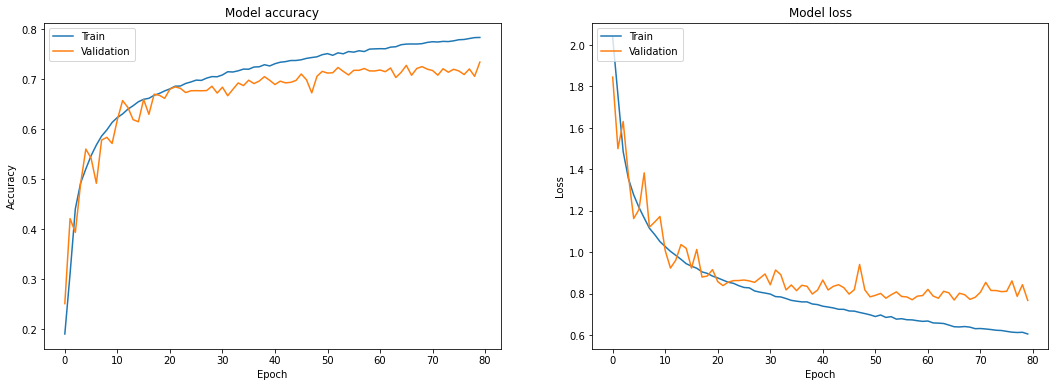

In [34]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
model.save('Fer.h5')

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

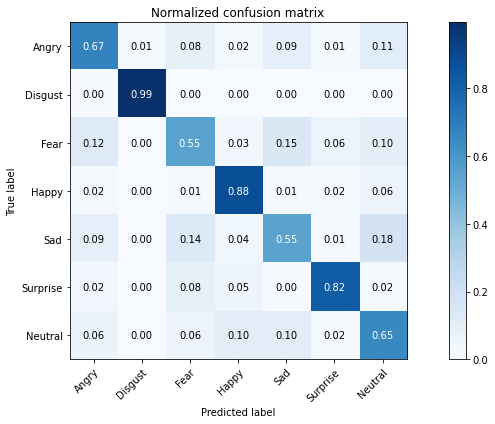

In [37]:
test_true = np.argmax(y_Test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

actual is surprise
predicted is surprise


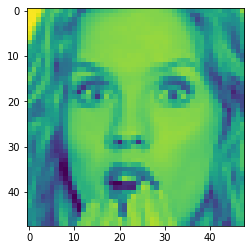

In [38]:
import tensorflow as tf
from IPython.display import clear_output
test_true = np.argmax(y_Test, axis=1)
from IPython.display import clear_output
import time
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'} 
for k in range(20):
  print(f'actual is {label_to_text[test_true[k]]}')
  predicted_label = model.predict(tf.expand_dims(X_test[k],0)).argmax()
  print(f'predicted is {label_to_text[predicted_label]}')
  plt.imshow(X_test[k].reshape(48,48))
  plt.show()
  time.sleep(5)
  clear_output(wait=True)